<a href="https://colab.research.google.com/github/AchinthaThennakoon/L4S2-FYP-UOM/blob/main/ViT_pre_trained_models/ViT_pre_trained_model_04_07_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers, models

In [33]:
def load_pretrained_vit_model():
    vit_url = "https://www.kaggle.com/models/spsayakpaul/vision-transformer/TensorFlow2/vit-b16-classification/1"  # Example URL, update as needed
    vit_model = hub.KerasLayer(vit_url, trainable=False)
    return vit_model

In [34]:
import PIL.Image as Image
import os

In [35]:
import numpy as np

In [36]:
import pathlib

In [37]:
import matplotlib.pyplot as plt

# With out training

In [38]:
pretrained_model = load_pretrained_vit_model()

In [39]:
IMAGE_SHAPE = (224,224)

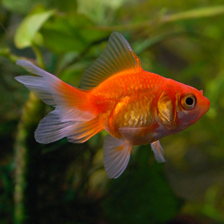

In [40]:
gold_fish = Image.open("/content/drive/MyDrive/Colab Notebooks/DL/CNN/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

array([[[ 72,  85,  18],
        [ 80,  95,  23],
        [ 89, 107,  30],
        ...,
        [ 84, 100,   1],
        [ 82,  98,   1],
        [ 79,  94,   0]],

       [[ 73,  85,  21],
        [ 83,  97,  28],
        [ 90, 108,  33],
        ...,
        [ 82,  97,   1],
        [ 80,  95,   1],
        [ 77,  92,   0]],

       [[ 73,  85,  22],
        [ 80,  94,  26],
        [ 88, 106,  33],
        ...,
        [ 81,  96,   1],
        [ 79,  94,   2],
        [ 76,  91,   1]],

       ...,

       [[ 14,  28,   4],
        [ 13,  29,   5],
        [ 13,  31,   6],
        ...,
        [ 40,  56,  10],
        [ 40,  57,   9],
        [ 41,  57,   8]],

       [[ 16,  32,   4],
        [ 15,  34,   5],
        [ 14,  35,   5],
        ...,
        [ 35,  52,  12],
        [ 36,  53,  11],
        [ 36,  53,   9]],

       [[ 17,  37,   3],
        [ 18,  39,   5],
        [ 14,  38,   3],
        ...,
        [ 29,  46,  11],
        [ 30,  47,  10],
        [ 30,  48,   9]]], dtype=uint8)
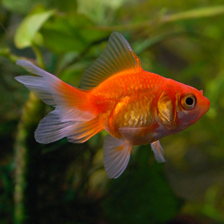

In [41]:
np.array(gold_fish)

In [42]:
gold_fish = np.array(gold_fish)/255

In [43]:
gold_fish.shape

(224, 224, 3)

In [44]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [45]:
model = models.Sequential([
    pretrained_model
])

In [46]:
result = model.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 5s 5s/step


(1, 1000)

In [47]:
predicted_label_index = np.argmax(result)
predicted_label_index

1

In [48]:
# maize leaf
IMAGE_SHAPE = (224,224)

maize_leaf = Image.open("/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs/Blight/Corn_Blight (111).JPG").resize(IMAGE_SHAPE)

results = model.predict((np.array(maize_leaf)/255)[np.newaxis, ...])

predicted_label_index = np.argmax(results)
predicted_label_index

1/1 [==============================] - 0s 23ms/step


998

# With Training

## Create Model

In [49]:
def create_pretrained_vit_model(input_shape, num_classes,pretrained_model):
  inputs = layers.Input(shape=input_shape)

  # Resize to 224x224
  resized_inputs = layers.Resizing(224, 224)(inputs)

  # Normalize pixel values to the range [-1, 1]
  normalized_inputs = layers.Lambda(lambda x: (x / 127.5) - 1.0)(resized_inputs)
  x = pretrained_model(normalized_inputs)

  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  model = models.Model(inputs, outputs)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


## loading data set

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs'

In [52]:
data_dir = pathlib.Path(dataset_path)
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/FYP_code/Disease_dataset/imgs')

In [53]:
train_ds,val_ds =  keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=123,
    )

Found 3821 files belonging to 2 classes.
Using 3057 files for training.
Using 764 files for validation.


In [54]:
class_names = train_ds.class_names
class_names

['Blight', 'Gray_Leaf_Spot']

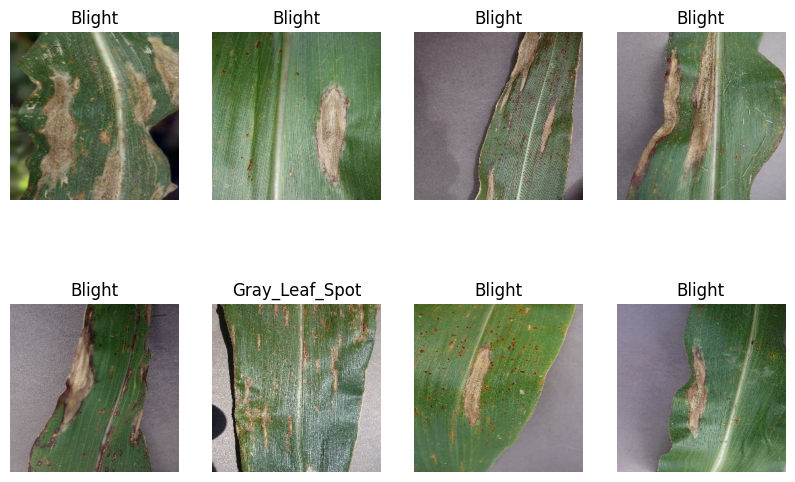

In [55]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## train model

In [56]:
input_shape = (256,256,3)
num_classes = len(class_names)

In [57]:
num_classes

2

In [58]:
epochs = 100
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [59]:
#load pre-train model
pre_trained_model = load_pretrained_vit_model()

In [60]:
def runExperiment():
  model = create_pretrained_vit_model(input_shape, num_classes,pre_trained_model)
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      verbose=1,
      epochs=epochs,
      callbacks=[early_stopping],
      batch_size=32
      )
  return history


In [61]:
history = runExperiment()

Epoch 1/100
96/96 [==============================] - 69s 651ms/step - loss: 0.5138 - accuracy: 0.7674 - val_loss: 0.2385 - val_accuracy: 0.8861
Epoch 2/100
96/96 [==============================] - 48s 493ms/step - loss: 0.3691 - accuracy: 0.8423 - val_loss: 0.1765 - val_accuracy: 0.9450
Epoch 3/100
96/96 [==============================] - 48s 490ms/step - loss: 0.2870 - accuracy: 0.8829 - val_loss: 0.1733 - val_accuracy: 0.9175
Epoch 4/100
96/96 [==============================] - 48s 496ms/step - loss: 0.2731 - accuracy: 0.8839 - val_loss: 0.1770 - val_accuracy: 0.9437
Epoch 5/100
96/96 [==============================] - 47s 482ms/step - loss: 0.2712 - accuracy: 0.8858 - val_loss: 0.1973 - val_accuracy: 0.9385
Epoch 6/100
96/96 [==============================] - 48s 496ms/step - loss: 0.2629 - accuracy: 0.8858 - val_loss: 0.1687 - val_accuracy: 0.9437
Epoch 7/100
96/96 [==============================] - 47s 484ms/step - loss: 0.2562 - accuracy: 0.8924 - val_loss: 0.1522 - val_accuracy:

In [1]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")

NameError: name 'plt' is not defined